In [1]:
%reset -f
import sys
sys.path.append("/home/puneeth/UofT/SpARG Project/sparg2.0-manuscript/sparg2.0")
import sparg as sparg
import tskit
import msprime
import numpy as np
import warnings
import matplotlib.pyplot as plt
import matplotlib as mpl
from importlib import reload
mpl.use("Qt5Agg")
reload(sparg)
warnings.simplefilter("always")

def locate_nodes(nodes, SpARG):
    """Calculate the location of the list of nodes

    Parameters
    ----------
    nodes : list
        List of nodes for which the locations will be calculated
    SpARG : SpatialARG
    	An instance of the SpatialARG class defined below. 

    Returns
    -------
    node_locations : dict
        The keys are the nodes. The values are the geographic location of the nodes in n dimensions
    variance_in_node_locations : dict
        The keys are the nodes. The values are the variance in the geographic location of the nodes in n dimensions
    """

    sigma = SpARG.dispersal_rate_matrix
    paths = SpARG.paths
    inverted_cov_mat = SpARG.inverted_paths_shared_time_matrix
    sample_locs_to_root_locs = SpARG.path_dispersal_distances
    root_locations = SpARG.root_locations
    node_shared_times = SpARG.node_paths_shared_times
    node_paths = SpARG.node_paths
    ts = SpARG.ts
    
    location_of_nodes = {} 
    variance_in_node_locations = {} 
    
    for i,node in enumerate(nodes): 
        node_specific_sharing = node_shared_times[node,:].copy()
        matmul_prod = np.matmul(node_specific_sharing, inverted_cov_mat)
        root_location = root_locations[node_paths[node][-1]]
        node_location = root_location + np.matmul(matmul_prod, sample_locs_to_root_locs)
        location_of_nodes[node] = node_location
        
        base_variance = np.matmul(matmul_prod, np.transpose(node_specific_sharing))
        ones = np.ones(inverted_cov_mat.shape[0])
        correction_denominator = np.matmul(np.matmul(np.transpose(ones),inverted_cov_mat),ones)
        correction_numerator = (1-np.matmul(np.matmul(np.transpose(node_specific_sharing),inverted_cov_mat),ones))**2
        corrected_variance_scaling_factor = (ts.max_root_time-ts.node(node).time)-base_variance+(correction_numerator/correction_denominator)
        total_variance_node = sigma*corrected_variance_scaling_factor
        variance_in_node_locations[node] = total_variance_node
    return location_of_nodes, variance_in_node_locations



def average_dispersal_treewise(ts, locations_of_nodes):
    branch_lengths = ts.tables.nodes.time[ts.tables.edges.parent] - ts.tables.nodes.time[ts.tables.edges.child]
    child_locations = np.array(list( map(locations_of_nodes.get, ts.tables.edges.child) ))
    parent_locations = np.array(list( map(locations_of_nodes.get, ts.tables.edges.parent) ))
    branch_distances = parent_locations - child_locations 
    ts_trees = ts.aslist()
    dispersal_rate = []
    average_dispersal_rate = []
    for ts_tree in ts_trees:     
        edge_ind = ts_tree.edge_array[ts_tree.edge_array>-1]
        tree_branch_lengths = branch_lengths[edge_ind]
        tree_branch_distances = branch_distances[edge_ind]
        tree_dispersal_rate = [ np.matmul( np.transpose([tree_branch_distances[i]]),[tree_branch_distances[i]] )/tree_branch_lengths[i] for i in range(len(tree_branch_distances)) ]
        tree_dispersal_rate = np.sum(np.array(tree_dispersal_rate), axis=0)/ts.num_samples   
        dispersal_rate += [tree_dispersal_rate]
        average_dispersal_rate += [ np.average(np.array(dispersal_rate), axis=0) ]
    return dispersal_rate, average_dispersal_rate 

# Code to generate data files for Fig 3

In [ ]:
ts = tskit.load("slim_0.25rep1sigma.trees")

for sd in range(4):
    print(sd)
    np.random.seed(sd)
    keep_nodes = list(np.random.choice(ts.samples(), 100, replace=False))
    
    ts_sim, sim_map = ts.simplify(samples=keep_nodes, keep_input_roots=False, keep_unary=True, map_nodes=True)
    ts_filtered, filtered_maps = sparg.simplify_with_recombination(ts=ts_sim)
    ts_chopped = sparg.chop_arg(ts_filtered,10000)
    FullARG = sparg.SpatialARG(ts=ts_chopped, dimensions=2, verbose=False)
    locations_of_nodes, var_nodes = locate_nodes(nodes = range(ts_chopped.num_nodes), SpARG = FullARG)
    dispersal_rate_treewise, average_dispersal_rate_treewise = average_dispersal_treewise(ts=ts_chopped, locations_of_nodes = locations_of_nodes)
    print("Step")
    
    outfile = open("slim_0.25rep1sigma_dispersalrateestimates_seqlen_100_chopped_10000_rep_" + str(sd) +".txt", "w")
    i = 0
    ts_breaks = ts_chopped.breakpoints(as_array=True)
    print(len(ts_breaks))
    FI1_trees = []
    FI2_trees = []
    sigma_trees = [] 
    for (bp_i,bp) in enumerate(ts_breaks):
        if bp_i > 0:
             if bp_i%10 == 0 or bp_i == 1 :
                if bp_i in range(0,1551,100):
                    print(sd, bp_i)
                ts_short = ts_chopped.keep_intervals(intervals=[(0,bp)], simplify=False).trim()
                ts_short_sim, maps_short_sim = sparg.simplify_with_recombination(ts=ts_short)
                ts_short_attached = sparg.chop_arg(ts=ts_short, time = ts_short.max_time )
                
                print(sd, bp_i,ts_breaks[bp_i-1], bp)
                ts_tree = ts_short_attached.keep_intervals(intervals=[(ts_breaks[bp_i-1],bp)], simplify=False).trim() 
                ts_tree = sparg.chop_arg(ts=ts_tree,time= ts_tree.max_time)
                
                PartialARG = sparg.SpatialARG(ts=ts_short_attached,dimensions=2, verbose=False)
                dispersal_rate = PartialARG.dispersal_rate_matrix
                FI1 = PartialARG.fishers_information_1
                FI2 = PartialARG.fishers_information_2 
                loc_nodes, var_nodes = locate_nodes(nodes = range(ts_short_attached.num_nodes), SpARG = PartialARG)
                
                disp_ARG, avg_disp_ARG = average_dispersal_treewise(ts=ts_short_attached, locations_of_nodes = loc_nodes)
                
                Tree = sparg.SpatialARG(ts=ts_tree, dimensions=2, verbose=False)
                
                dispersal_rate_tree = Tree.dispersal_rate_matrix
                FI1_tree = Tree.fishers_information_1 
                FI2_tree = Tree.fishers_information_2
                               
                FI1_trees += [ dispersal_rate_tree[0][0]**2*FI1 ]
                FI2_trees += [ dispersal_rate_tree[0][0]**3*FI2 ]
                sigma_trees += [ dispersal_rate_tree[0][0] ]

                sigma_avg = np.average(sigma_trees)
                FI1_avg = np.sum(FI1_trees)/(sigma_avg**2)
                FI2_avg = np.sum(FI2_trees)/(sigma_avg**3)

                outfile.write(str(ts_short_attached.num_trees) + " " + str(bp) + " " + str(dispersal_rate[0][0]) + " " + str(dispersal_rate[1][1]) + " " + str(FI1 + FI2)+ " " + str(sigma_avg) + " " + str(FI1_avg + FI2_avg) + " " + str(dispersal_rate_treewise[bp_i][0][0])+ " " + str(dispersal_rate_treewise[bp_i][1][1]) + " " + str(average_dispersal_rate_treewise[bp_i][0][0])+ " " + str(average_dispersal_rate_treewise[bp_i][1][1]) + " " + str(avg_disp_ARG[-1][0][0])+ " " + str(avg_disp_ARG[-1][1][1]) + "\n")
                
    outfile.close()

    

0
Step
1546
0 1 0.0 1459.0
0 10 6280.0 7383.0
0 20 12480.0 13566.0
0 30 16482.0 16602.0
0 40 20792.0 21091.0
0 50 26847.0 27782.0
0 60 34720.0 34826.0
0 70 44035.0 47359.0
0 80 52541.0 53742.0
0 90 55311.0 55610.0
0 100
0 100 63190.0 63489.0
0 110 68839.0 68870.0
0 120 72371.0 73190.0
0 130 80523.0 81401.0
0 140 85756.0 85988.0
0 150 93754.0 95401.0
0 160 104354.0 104981.0
0 170 110077.0 110542.0
0 180 120760.0 121147.0
0 190 125695.0 126360.0
0 200
0 200 130828.0 131858.0
0 210 135743.0 137387.0
0 220 141142.0 141240.0
0 230 149029.0 149117.0
0 240 161804.0 162177.0
0 250 165626.0 166292.0
0 260 171517.0 171783.0
0 270 176516.0 179293.0
0 280 185035.0 186656.0
0 290 192614.0 192885.0
0 300
0 300 197455.0 197766.0
0 310 202085.0 202589.0
0 320 212423.0 213482.0
0 330 219364.0 219779.0
0 340 227999.0 228037.0
0 350 233709.0 233831.0
0 360 239446.0 239732.0
0 370 243901.0 244415.0
0 380 251324.0 251825.0
0 390 257159.0 258483.0
0 400
0 400 265536.0 265917.0
0 410 271359.0 274772.0
0 420 

In [51]:
ts = tskit.load("slim_0.25rep1sigma.trees")


sd = 1
np.random.seed(sd)
keep_nodes = list(np.random.choice(ts.samples(), 100, replace=False))
ts_sim, sim_map = ts.simplify(samples=keep_nodes, keep_input_roots=False, keep_unary=True, map_nodes=True)
ts_filtered, filtered_maps = sparg.simplify_with_recombination(ts=ts_sim)
ts_chopped = sparg.chop_arg(ts_sim,10000)
print(len(ts_chopped.tables.edges))


d = 0 
d_sqrt = 0
n = 0

unique_edges = np.unique(np.column_stack((ts_chopped.edges_child, ts_chopped.edges_parent)), axis=0)
child_individuals = ts_chopped.tables.nodes.individual[np.array(unique_edges[:,0]) ]
parent_individuals = ts_chopped.tables.nodes.individual[np.array(unique_edges[:,1]) ]

child_locations = ts_chopped.tables.individuals[child_individuals].location.reshape(len(unique_edges),3) 
parent_locations = ts_chopped.tables.individuals[parent_individuals].location.reshape(len(unique_edges),3)

child_times = ts_chopped.tables.nodes.time[unique_edges[:,0]]
parent_times = ts_chopped.tables.nodes.time[unique_edges[:,1]]

disp_x = np.sum((child_locations[:,0]-parent_locations[:,0])**2/([parent_times-child_times]),axis=1)/len(unique_edges)
disp_y = np.sum((child_locations[:,1]-parent_locations[:,1])**2/([parent_times-child_times]),axis=1)/len(unique_edges)

print(disp_x, disp_y)


1163250
[0.43418314] [0.4331588]


# Code to generate Plots for Fig 3

## Code for Fig 3A 

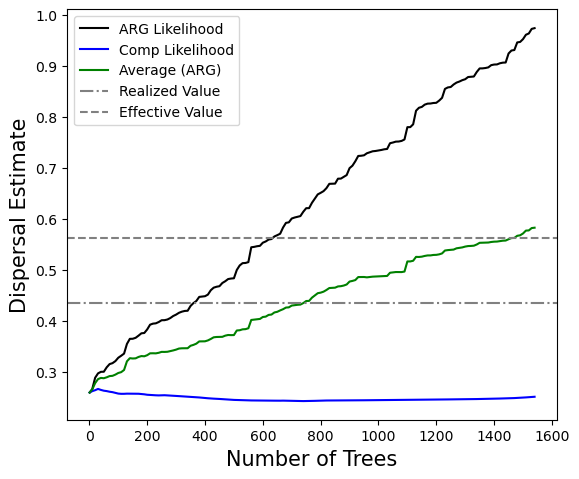

In [66]:
%matplotlib inline

dispersal_1 = np.loadtxt("slim_0.25rep1sigma_dispersalrateestimates_seqlen_100_chopped_10000_rep_0.txt")
plt.figure(figsize=(5.9,4.9))

plt.plot(dispersal_1[:,0], dispersal_1[:,2], color='black', label = "ARG Likelihood")
#plt.plot(dispersal_1[:,0], dispersal_1[:,9], color = 'red', linestyle = "dashdot", label = "Average w/ Full ARG")
plt.plot(dispersal_1[:,0], dispersal_1[:,5], color = 'blue', label = "Comp Likelihood")
plt.plot(dispersal_1[:,0], dispersal_1[:,11], color = 'green', label = "Average (ARG)")
#plt.plot(dispersal_1[3:len(dispersal_1[:,0])-2,0], dispersal_1[3:len(dispersal_1[:,0])-2,13], color = 'red', label = "W 20")

plt.axhline(y=disp_x,label = "Realized Value", linestyle = '-.', color = 'grey')
plt.axhline(y=0.25**2+0.5,label = "Effective Value", linestyle = '--', color = 'grey')


plt.legend()
plt.xlabel("Number of Trees", fontsize = 15)
plt.ylabel("Dispersal Estimate", fontsize = 15)
plt.tight_layout()
plt.savefig('DispRate.svg', format='svg')
plt.show()

## Code for Fig 3B

In [5]:
%matplotlib qt


dispersal_1 = np.loadtxt("slim_0.25rep1sigma_dispersalrateestimates_seqlen_100_chopped_10000_rep_0.txt")
dispersal_2 = np.loadtxt("slim_0.25rep1sigma_dispersalrateestimates_seqlen_100_chopped_10000_rep_1.txt")
dispersal_3 = np.loadtxt("slim_0.25rep1sigma_dispersalrateestimates_seqlen_100_chopped_10000_rep_2.txt")
dispersal_4 = np.loadtxt("slim_0.25rep1sigma_dispersalrateestimates_seqlen_100_chopped_10000_rep_3.txt")


plt.figure()

plt.plot(dispersal_1[:,0], np.sqrt(1/(np.array(dispersal_1[:,4])*np.array(dispersal_1[:,2])*np.array(dispersal_1[:,2]))), color = 'red' ) 
plt.plot(dispersal_1[:,0], np.sqrt(1/(np.array(dispersal_1[:,6])*np.array(dispersal_1[:,5])*np.array(dispersal_1[:,5]))), linestyle= '--', color ='red' ) 

plt.plot(dispersal_2[:,0], np.sqrt(1/(np.array(dispersal_2[:,4])*np.array(dispersal_2[:,2])*np.array(dispersal_2[:,2]))), color ='blue' ) 
plt.plot(dispersal_2[:,0], np.sqrt(1/(np.array(dispersal_2[:,6])*np.array(dispersal_2[:,5])*np.array(dispersal_2[:,5]))), linestyle= '--', color ='blue' ) 

plt.plot(dispersal_3[:,0], np.sqrt(1/(np.array(dispersal_3[:,4])*np.array(dispersal_3[:,2])*np.array(dispersal_3[:,2]))), color = 'orange' ) 
plt.plot(dispersal_3[:,0], np.sqrt(1/(np.array(dispersal_3[:,6])*np.array(dispersal_3[:,5])*np.array(dispersal_3[:,5]))), linestyle= '--', color ='orange' ) 

plt.plot(dispersal_4[:,0], np.sqrt(1/(np.array(dispersal_4[:,4])*np.array(dispersal_4[:,2])*np.array(dispersal_4[:,2]))), color ='green' ) 
plt.plot(dispersal_4[:,0], np.sqrt(1/(np.array(dispersal_4[:,6])*np.array(dispersal_4[:,5])*np.array(dispersal_4[:,5]))), linestyle= '--', color ='green' ) 

plt.xlabel("Number of Trees", fontsize = 20)
plt.ylabel("Coefficient of Variantion", fontsize = 20)
plt.show()

plt.figure()


plt.plot(dispersal_1[:,0], np.sqrt(1/(np.array(dispersal_1[:,4])*np.array(dispersal_1[:,2])*np.array(dispersal_1[:,2]))), color = 'red' ) 
plt.plot(dispersal_1[:,0], np.sqrt(1/(np.array(dispersal_1[:,6])*np.array(dispersal_1[:,5])*np.array(dispersal_1[:,5]))), linestyle= '--', color ='red' ) 

plt.plot(dispersal_2[:,0], np.sqrt(1/(np.array(dispersal_2[:,4])*np.array(dispersal_2[:,2])*np.array(dispersal_2[:,2]))), color ='blue' ) 
plt.plot(dispersal_2[:,0], np.sqrt(1/(np.array(dispersal_2[:,6])*np.array(dispersal_2[:,5])*np.array(dispersal_2[:,5]))), linestyle= '--', color ='blue' ) 

plt.plot(dispersal_3[:,0], np.sqrt(1/(np.array(dispersal_3[:,4])*np.array(dispersal_3[:,2])*np.array(dispersal_3[:,2]))), color = 'orange' ) 
plt.plot(dispersal_3[:,0], np.sqrt(1/(np.array(dispersal_3[:,6])*np.array(dispersal_3[:,5])*np.array(dispersal_3[:,5]))), linestyle= '--', color ='orange' ) 

plt.plot(dispersal_4[:,0], np.sqrt(1/(np.array(dispersal_4[:,4])*np.array(dispersal_4[:,2])*np.array(dispersal_4[:,2]))), color ='green' ) 
plt.plot(dispersal_4[:,0], np.sqrt(1/(np.array(dispersal_4[:,6])*np.array(dispersal_4[:,5])*np.array(dispersal_4[:,5]))), linestyle= '--', color ='green' ) 

plt.xlabel("Number of Trees", fontsize = 20)
plt.ylabel("Coefficient of Variantion", fontsize = 20)
plt.show()

plt.ylim([0.127, 0.134])


"""
plt.plot(dispersal_1[:,0], dispersal_1[:,5])
plt.plot(dispersal_2[:,0], dispersal_2[:,5])
plt.plot(dispersal_3[:,0], dispersal_3[:,5])
plt.plot(dispersal_4[:,0], dispersal_4[:,5])
plt.xlabel("Number of Trees")
plt.ylabel("Dispersal Estimate - Rnk")
plt.show()

plt.plot(dispersal_1[:,0], 1/dispersal_1[:,7])
plt.plot(dispersal_2[:,0], 1/dispersal_2[:,7])
plt.plot(dispersal_3[:,0], 1/dispersal_3[:,7])
plt.plot(dispersal_4[:,0], 1/dispersal_4[:,7])
plt.xlabel("Number of Treees")
plt.ylabel("Inverse of Fisher Info Index - Rnk")
plt.show()
"""

'\nplt.plot(dispersal_1[:,0], dispersal_1[:,5])\nplt.plot(dispersal_2[:,0], dispersal_2[:,5])\nplt.plot(dispersal_3[:,0], dispersal_3[:,5])\nplt.plot(dispersal_4[:,0], dispersal_4[:,5])\nplt.xlabel("Number of Trees")\nplt.ylabel("Dispersal Estimate - Rnk")\nplt.show()\n\nplt.plot(dispersal_1[:,0], 1/dispersal_1[:,7])\nplt.plot(dispersal_2[:,0], 1/dispersal_2[:,7])\nplt.plot(dispersal_3[:,0], 1/dispersal_3[:,7])\nplt.plot(dispersal_4[:,0], 1/dispersal_4[:,7])\nplt.xlabel("Number of Treees")\nplt.ylabel("Inverse of Fisher Info Index - Rnk")\nplt.show()\n'